# Preprocessing

In [20]:
#!pip install yfinance pmdarima --quiet

import math
import pandas as pd
import numpy as np
from statsmodels.tsa.base.tsa_model import TimeSeriesModel

import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox


In [122]:
cocoa_price_raw = pd.read_csv("Daily Prices_ICCO.csv")
cocoa_price_raw.columns.values[1] = "PRICE"
cocoa_price_raw.columns.values[0] = "DATE"
cocoa_price_raw['DATE'] = pd.to_datetime(cocoa_price_raw['DATE'])
cocoa_price_raw['PRICE'] = cocoa_price_raw['PRICE'].astype(str).str.replace(',', '').astype(float)



#Sorting
cocoa_price = cocoa_price_raw.sort_values(by='DATE').reset_index(drop = True)

/tmp/ipykernel_143/4214966193.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cocoa_price_raw['DATE'] = pd.to_datetime(cocoa_price_raw['DATE'])


#### Outlier

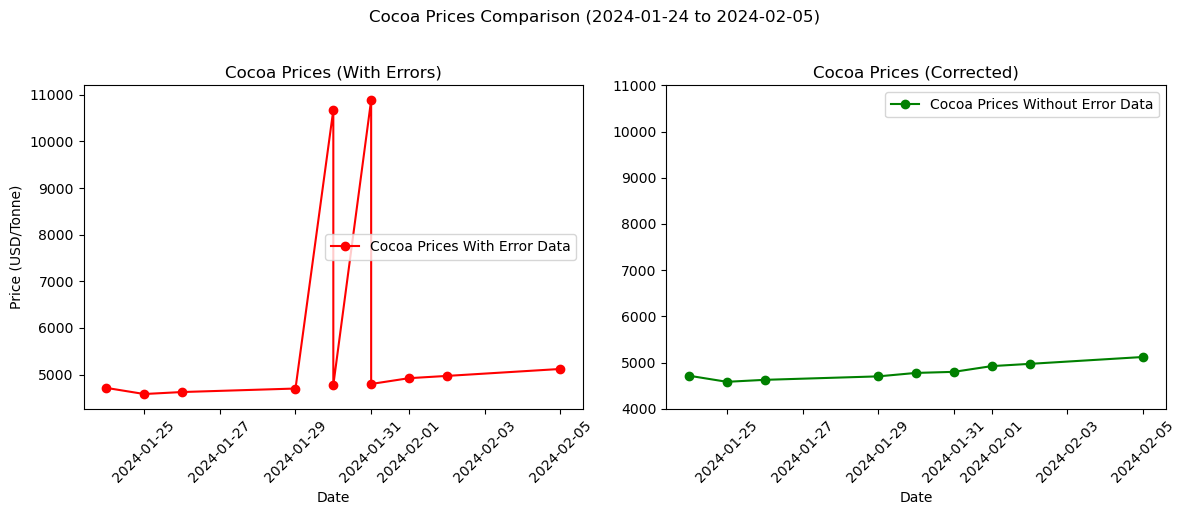

In [123]:
cocoa_outlier = cocoa_price[(cocoa_price['DATE']> '2024-01-23') & (cocoa_price['DATE']<'2024-02-06')]
cocoa_true = cocoa_outlier.drop(7531)
cocoa_true = cocoa_true.drop(7533)
cocoa_true

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 1 (Outliers)
ax1.plot(cocoa_outlier['DATE'], cocoa_outlier['PRICE'], 
         label='Cocoa Prices With Error Data', 
         marker='o', color='red')
ax1.set_title('Cocoa Prices (With Errors)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD/Tonne)')
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks
ax1.legend()

# Plot 2 (True Data)
ax2.plot(cocoa_true['DATE'], cocoa_true['PRICE'], 
         label='Cocoa Prices Without Error Data', 
         marker='o', color='green')
ax2.set_title('Cocoa Prices (Corrected)')
ax2.set_xlabel('Date')
ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks
ax2.set_ylim(4000, 11000)
ax2.legend()

plt.suptitle('Cocoa Prices Comparison (2024-01-24 to 2024-02-05)', y=1.02)
plt.tight_layout()
plt.show()

#### Removing error data

In [124]:
# Removing Error Data
cocoa_price.drop(7531, inplace = True)
cocoa_price.drop(7533, inplace = True)

cocoa_price = cocoa_price[cocoa_price['DATE']> '2023-01-01']

cocoa_price['abs_perc_change'] = abs((cocoa_price['PRICE'] - cocoa_price['PRICE'].shift(1)) / cocoa_price['PRICE'].shift(1))
cocoa_price['returns'] = np.log(cocoa_price['PRICE']/cocoa_price['PRICE'].shift(1))
cocoa_price = cocoa_price.dropna()

#### Assessing Stationarity

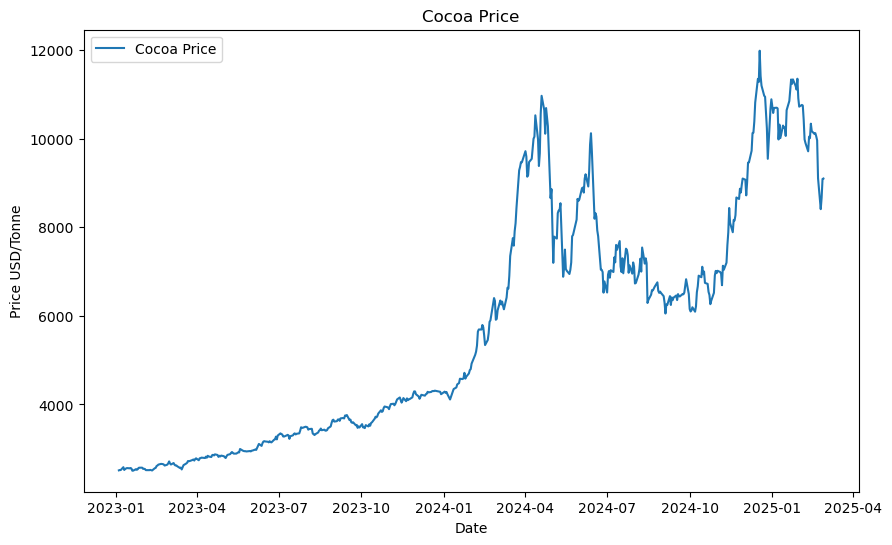

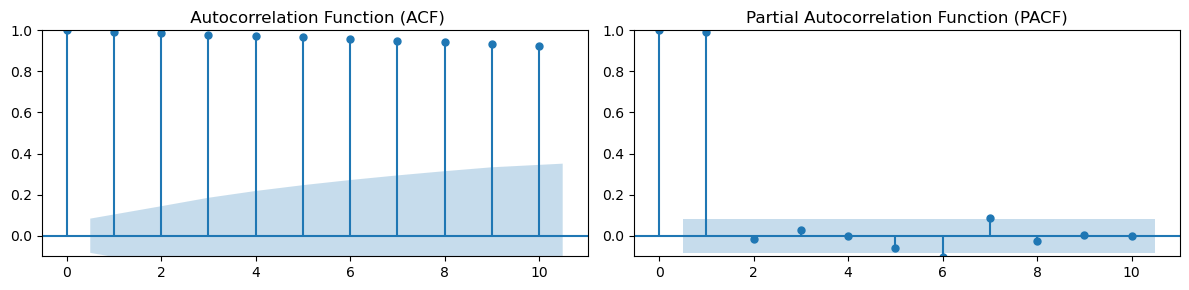

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cocoa_price['DATE'], cocoa_price['PRICE'], label='Cocoa Price')

ax.set_title('Cocoa Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price USD/Tonne')
ax.legend()
plt.show()

# ACF, PACF

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# ACF Plot up to 2024-01
plot_acf(cocoa_price['PRICE'], lags=10, ax=ax[0])
ax[0].set_title(" Autocorrelation Function (ACF)")
ax[0].set_ylim(-0.1, 1)

# PACF Plot up to 2024-01
plot_pacf(cocoa_price['PRICE'], lags=10, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_ylim(-0.1, 1)
plt.tight_layout()
plt.show()

In [48]:
# ADF
result = adfuller(cocoa_price['PRICE'].dropna())  # Drop NaN if any
print('p-value:', result[1])

p-value: 0.7620782719049088


# Regime Analysis

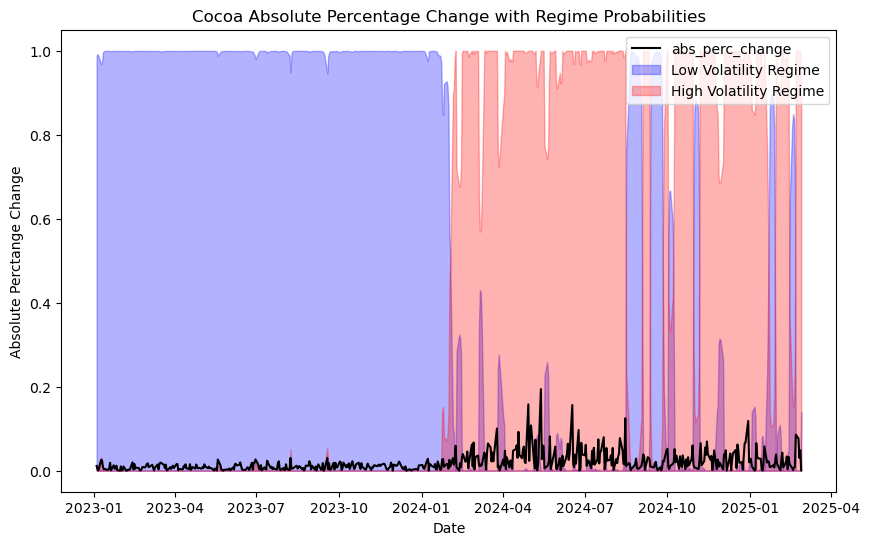

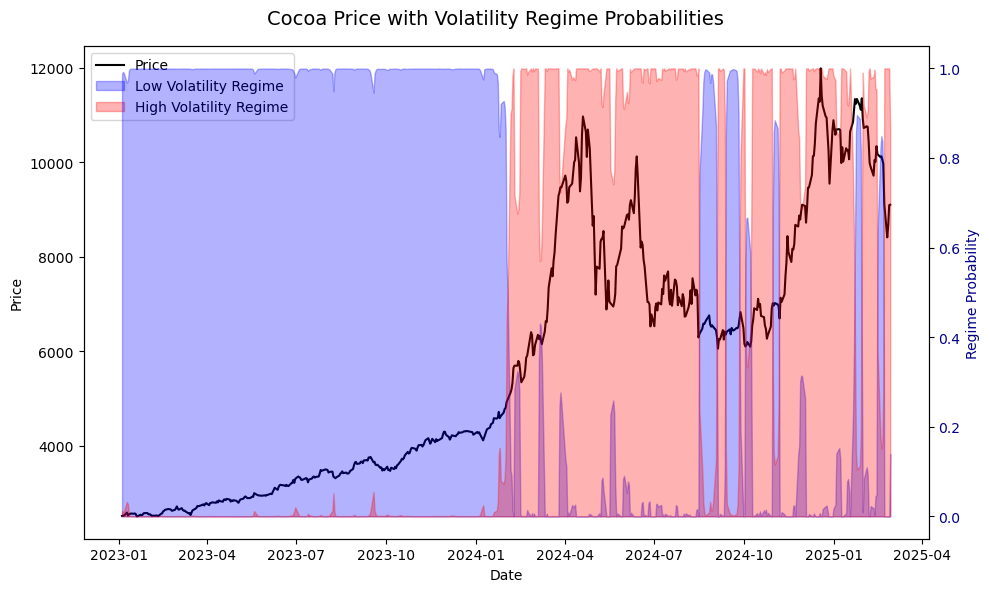

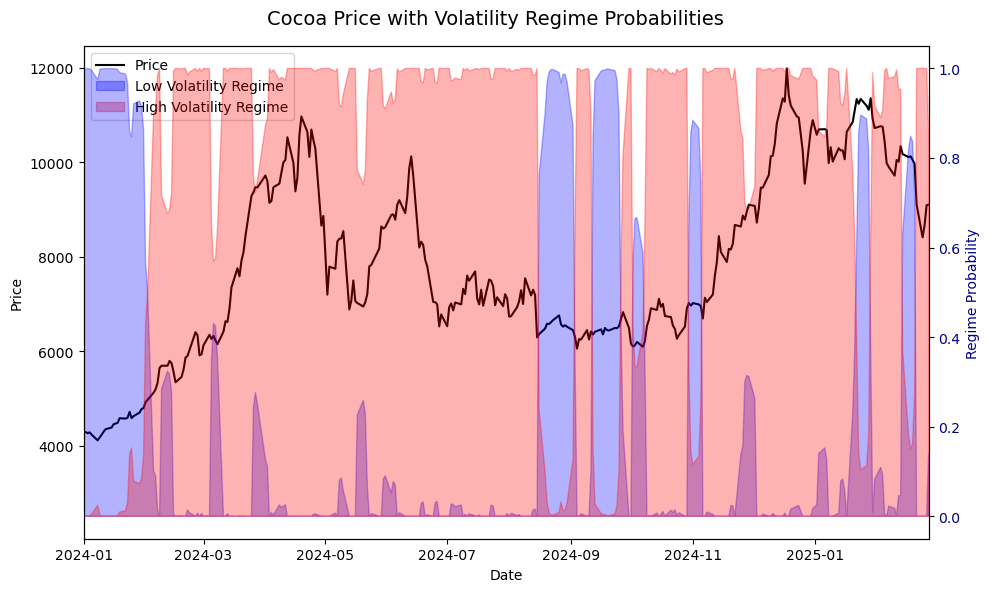

In [75]:
MSM_model = MarkovRegression(cocoa_price['abs_perc_change'], k_regimes=2, switching_variance=True)
results = MSM_model.fit()
cocoa_price = pd.concat([cocoa_price, results.smoothed_marginal_probabilities], axis = 1)
print(results.summary())

# Portion of regime 0
print(f'\nProportion of regime0 {(cocoa_price[0]>0.5).sum()/(cocoa_price[0].count())})

# Plot the smoothed probabilities of being in each regime
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(cocoa_price['DATE'], cocoa_price['abs_perc_change'], label='abs_perc_change', color='black')
ax.fill_between(cocoa_price['DATE'], 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
ax.fill_between(cocoa_price['DATE'], 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime')

ax.set_title('Cocoa Absolute Percentage Change with Regime Probabilities')
ax.set_xlabel('Date')
ax.set_ylabel('Absolute Perctange Change')
ax.legend()
plt.show()


# Cocoa Prices with regime
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot price data on the primary axis
ax1.plot(cocoa_price['DATE'], cocoa_price['PRICE'], label='Price', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot regime probabilities on the secondary axis
ax2.fill_between(cocoa_price['DATE'], 0, results.smoothed_marginal_probabilities[0], 
                color='blue', alpha=0.3, label='Low Volatility Regime')
ax2.fill_between(cocoa_price['DATE'], 0, results.smoothed_marginal_probabilities[1], 
                color='red', alpha=0.3, label='High Volatility Regime')
ax2.set_ylabel('Regime Probability', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Add a title
fig.suptitle('Cocoa Price with Volatility Regime Probabilities', fontsize=14)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()


#Cocoa Prices with Regime, Zoomed in
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot price data on the primary axis
ax1.plot(cocoa_price['DATE'], cocoa_price['PRICE'], label='Price', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot regime probabilities on the secondary axis
ax2.fill_between(cocoa_price['DATE'], 0, results.smoothed_marginal_probabilities[0], 
                color='blue', alpha=0.3, label='Low Volatility Regime')
ax2.fill_between(cocoa_price['DATE'], 0, results.smoothed_marginal_probabilities[1], 
                color='red', alpha=0.3, label='High Volatility Regime')
ax2.set_ylabel('Regime Probability', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

start_date = "2024-01-01"  # Replace with the desired start date
end_date = "2025-02-27"    # Replace with the desired end date
ax1.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Add a title
fig.suptitle('Cocoa Price with Volatility Regime Probabilities', fontsize=14)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

In [6]:
# Separating Dataset
cocoa_price_regime0 = cocoa_price[cocoa_price['DATE'] < '2024-01-01']
cocoa_price_regime0.tail()

,DATE,PRICE,abs_perc_change,returns,0,1
7505,2023-12-21,4301.20,0.000757,-0.000758,0.999470,0.000530
7506,2023-12-22,4311.54,0.002404,0.002401,0.999565,0.000435
7507,2023-12-26,4293.07,0.004284,-0.004293,0.999629,0.000371
7508,2023-12-28,4285.61,0.001738,-0.001739,0.999558,0.000442
7509,2023-12-29,4231.52,0.012621,-0.012702,0.999580,0.000420


# ARIMA

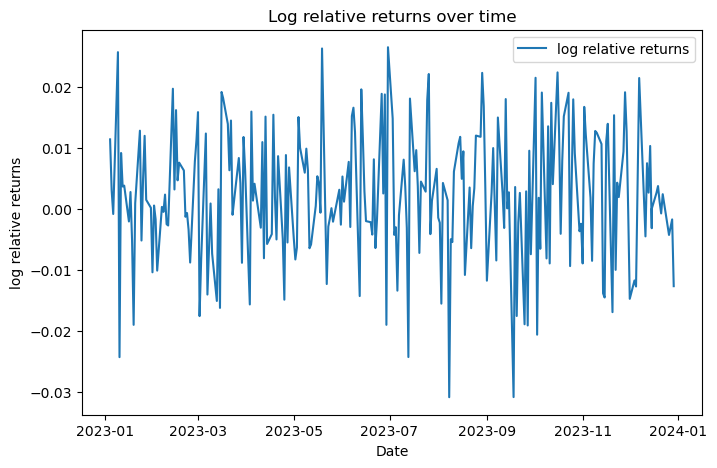

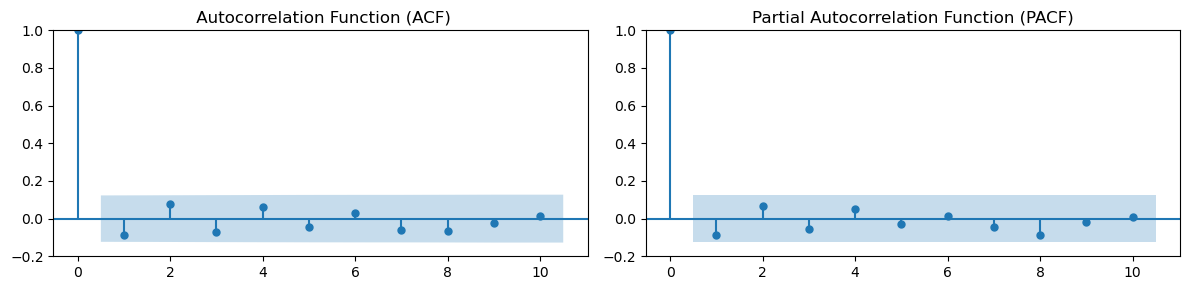

In [81]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(cocoa_price_regime0['DATE'], cocoa_price_regime0['returns'], label='log relative returns')

ax.set_title('Log relative returns over time')
ax.set_xlabel('Date')
ax.set_ylabel('log relative returns')
ax.legend()
plt.show()

# ACF, PACF

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# ACF Plot up to 2024-01
plot_acf(cocoa_price_regime0['returns'], lags=10, ax=ax[0])
ax[0].set_title(" Autocorrelation Function (ACF)")
ax[0].set_ylim(-0.2, 1)

# PACF Plot up to 2024-01
plot_pacf(cocoa_price_regime0['returns'], lags=10, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_ylim(-0.2, 1)
plt.tight_layout()
plt.show()

In [82]:
# ADF
adf = adfuller(cocoa_price_regime0['returns'].dropna())  # Drop NaN if any
print('p-value:', adf[1])

p-value: 6.555363534140767e-30


In [7]:
regime0_model1 = pm.auto_arima(cocoa_price_regime0['returns'], seasonal=False, stepwise=True, suppress_warnings=True)
regime0_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  253
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 790.498
Date:                Fri, 04 Apr 2025   AIC                          -1572.997
Time:                        19:55:45   BIC                          -1558.863
Sample:                             0   HQIC                         -1567.310
                                - 253                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.001      3.085      0.002       0.001       0.006
ar.L1         -0.7659      0.247     -3.106      0.002      -1.249      -0.283
ma.L1          0.6805      0.278      2.448      0.014       0.136       1.225
sigma2         0.0001   1.04e-05     10.853      0.000    9.27e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.84   Prob(JB):                         0.33
Heteroskedasticity (H):               1.26   Skew:                            -0.23
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# Much Faster calculation than auto arima, but the results are very similar See Coding Appendix 
regime0_model = ARIMA(cocoa_price_regime0['returns'], order = (1,0,1))
regime0_model = regime0_model.fit()
regime0_model.summary()

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  253
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 789.507
Date:                Fri, 04 Apr 2025   AIC                          -1571.015
Time:                        19:55:50   BIC                          -1556.881
Sample:                             0   HQIC                         -1565.328
                                - 253                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.214      0.001       0.001       0.003
ar.L1         -0.9001      0.105     -8.565      0.000      -1.106      -0.694
ma.L1          0.8238      0.123      6.675      0.000       0.582       1.066
sigma2         0.0001   1.05e-05     10.829      0.000    9.33e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.95   Prob(JB):                         0.29
Heteroskedasticity (H):               1.26   Skew:                            -0.24
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Regime 1 ~ EWMA


In [10]:
def EWMA_forecast(data, lamda):
    """
    Returns next day forecast
    
    Args:
        data: Input time series (array-like)
        lmbda: Lambda parameter between 0 and 1
               Higher lambda gives more weight to recent observations
    """
#     smooth = np.zeros_like(data, dtype=float)
#     smooth[0] = data[0]

#     for t in range(1, len(data)):
#         smooth[t] = lamda * data[t] + (1 - lamda) * smooth[t-1]
    
#     return smooth[-1]
    
    # Much faster
    return pd.Series(data).ewm(alpha=lamda, adjust=False).mean().iloc[-1]


# Markov Switching Model Integration

#### Model 1: 101 + EWMA
#### Model 2: 101 ONLY


In [11]:
# Usage 1 forecast(n)
    # n = number of days to forecast beginning at 2024-08-20
# Usage 2 forecast(n, lamda, damping, update, mode)
    # lambda = decay factor in EWMA
    # update = optional parameter to update real prices, ie update = 5 will begin forecast at 2024-08-28
    # damping = damping factor in EWMA
    # mode = 0, return both models, = 1 return model 1 - ARIMA + EWMA, = 2 return model 2 - ARIMA
def MSM_forecast(n: int, update: int = 0, lamda: float = 0.94, damping: float = 1, mode = 0) -> pd.DataFrame:
    """ 
    Forecasts n days from 2024-08-20
    Optionally forecasts beginning from update
    Returns a dataframe of FIVE columns: [DATE, PRICE, m1_pred_prices, m2_pred_prices, m3_pred_prices, m4_pred_prices]
    (PRICE is true price)
    """
    cocoa_forecast = cocoa_price.loc[:7675 + update]
    
    #last_row.get(): DATE,PRICE,returns,0,1
    last_row = cocoa_forecast.iloc[-1]
    
    # Generate forecasting Dates
    return_df = cocoa_price.loc[7675 + update + 1: 7675 + n + update]
    return_df = return_df[['DATE', 'PRICE']]
    # temporary returns_lst
    returns_lst = list(cocoa_forecast['returns'])
    

    # Model 1 - ARIMA + EWMA
    m1_pred_prices = []
    if last_row.get(0) > 0.5:
        # Apply model to updated data (retain the same coefficients, models is not retrained, just applied.)
        updated_m1 = regime0_model.apply(returns_lst, refit = False)
        # Obtain forecasted returns
        m1_pred_returns = list(updated_m1.forecast(steps = n))
        
    # Regime 1
    else:
        m1_pred_returns = []
        for i in range(n):
            m1_pred_returns.append((damping ** (i+1)) * EWMA_forecast(returns_lst, lamda))
            returns_lst.append(m1_pred_returns[i])

    # Convert returns to prices
    for index in range(len(m1_pred_returns)):
        if m1_pred_prices == []:
            m1_pred_prices.append(math.exp(m1_pred_returns[index]) * last_row.get("PRICE"))
        else:
            m1_pred_prices.append(math.exp(m1_pred_returns[index]) * m1_pred_prices[index - 1])
    
    if mode == 1:
        return_df['m1_pred_prices'] = m1_pred_prices
        return return_df
    
    # Reset
    returns_lst = list(cocoa_forecast['returns'])
    # Model 2 - ARIMA ONLY
    m2_pred_prices = []
    # Apply model to updated data (retain the same coefficients, models is not retrained, just applied.)
    updated_m2 = regime0_model.apply(returns_lst, refit=False)
    # Obtain forecasted returns
    m2_pred_returns = list(updated_m2.forecast(steps = n))


    # Convert returns to prices
    for index in range(len(m2_pred_returns)):
        if m2_pred_prices == []:
            m2_pred_prices.append(math.exp(m2_pred_returns[index]) * last_row.get("PRICE"))
        else:
            m2_pred_prices.append(math.exp(m2_pred_returns[index]) * m2_pred_prices[index - 1])
    if mode == 2:
        return_df['m2_pred_prices'] = m2_pred_prices
        return return_df
    
    return_df['m1_pred_prices'] = m1_pred_prices
    return_df['m2_pred_prices'] = m2_pred_prices
    
    return return_df
    

# MAE Function for  3 Day prediction

In [12]:
def MAE(horizon, lamda: float, damp: float, mode: int) -> float:
    """ Returns a dataframe of [model, 1day_mae, 3day_mae, 5day_mae]"""

    # 3 Day Forecast for 135 days (70 predictions)
    df_3day = pd.DataFrame()
    for day in range(int(70/horizon)):
        df_3day = pd.concat([df_3day, MSM_forecast(horizon, day * horizon, lamda, damp, mode)], axis = 0)
    
    true_price = list(df_3day['PRICE'])
    if mode == 1:
        prediction_price = list(df_3day['m1_pred_prices'])
    if mode == 2:
        prediction_price = list(df_3day['m2_pred_prices'])
   

    m1_3day_error = []
    for day in range(len(prediction_price)):
        m1_3day_error.append(abs(prediction_price[day] - true_price[day]))

    mae = sum(m1_3day_error)/135

    return mae



# MAE Matrix for finding EWMA parameters

In [87]:
def MAE_matrix(horizon) -> pd.DataFrame:
    """
    Outputs a dataframe of 
    columns: decay factor λ in [0.94, 0.84, 0.74, ..., 0.04]
    rows: damping factor η in [1, 0.9, 0.8,...,0.1]
    """
    MAE_matrix = pd.DataFrame()
    MAE_matrix['model'] = ['damping η1', 'damping η0.9', 'damping η0.8', 'damping η0.7', 'damping η0.6', 'damping η0.5', 'damping η0.4', 'damping η0.3', 'damping η0.2', 'damping η0.1']
    for lamda in [0.94,0.84,0.74,0.64,0.54,0.44,0.34,0.24,0.14,0.04]:
        column_mae_lst = []
        for damp in [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
            column_mae_lst.append(MAE(horizon, lamda, damp, 1))
        MAE_matrix[f'decay λ{lamda}'] = column_mae_lst
    return MAE_matrix
        

In [88]:
MAE_matrix = MAE_matrix(3)
MAE_matrix

,model,decay λ0.94,decay λ0.84,decay λ0.74,decay λ0.64,decay λ0.54,decay λ0.44,decay λ0.34,decay λ0.24,decay λ0.14,decay λ0.04
0,damping η1,185.275530,175.573687,166.794820,162.003303,156.793611,151.878153,145.234371,136.395801,126.140758,114.949118
1,damping η0.9,161.458298,155.500208,152.354308,149.236507,146.567844,142.892115,137.770714,130.929137,123.140355,114.481128
2,damping η0.8,145.029271,143.196358,141.673172,140.234589,138.247160,135.451114,131.470526,126.483367,120.620427,114.209249
3,damping η0.7,135.419870,134.793699,133.989075,132.897016,131.378467,129.220493,126.201465,122.939440,118.645864,113.972157
4,damping η0.6,128.821720,128.357485,127.741795,126.918160,126.035780,124.617432,122.601971,120.018237,117.103616,113.752657
5,damping η0.5,123.994663,123.602552,123.112256,122.764303,122.090477,120.978571,119.678765,118.089797,116.035152,113.549183
6,damping η0.4,119.847691,119.646402,119.522996,119.226524,118.690752,118.120410,117.446578,116.429163,115.092659,113.360246
7,damping η0.3,116.520615,116.478547,116.387228,116.303909,116.249002,116.080831,115.690773,115.201874,114.277625,113.184430
8,damping η0.2,114.370360,114.452681,114.515064,114.540279,114.508210,114.470440,114.391259,114.137205,113.717702,113.020375
9,damping η0.1,113.206339,113.278945,113.346617,113.406950,113.456709,113.487876,113.482168,113.404918,113.201350,112.866771


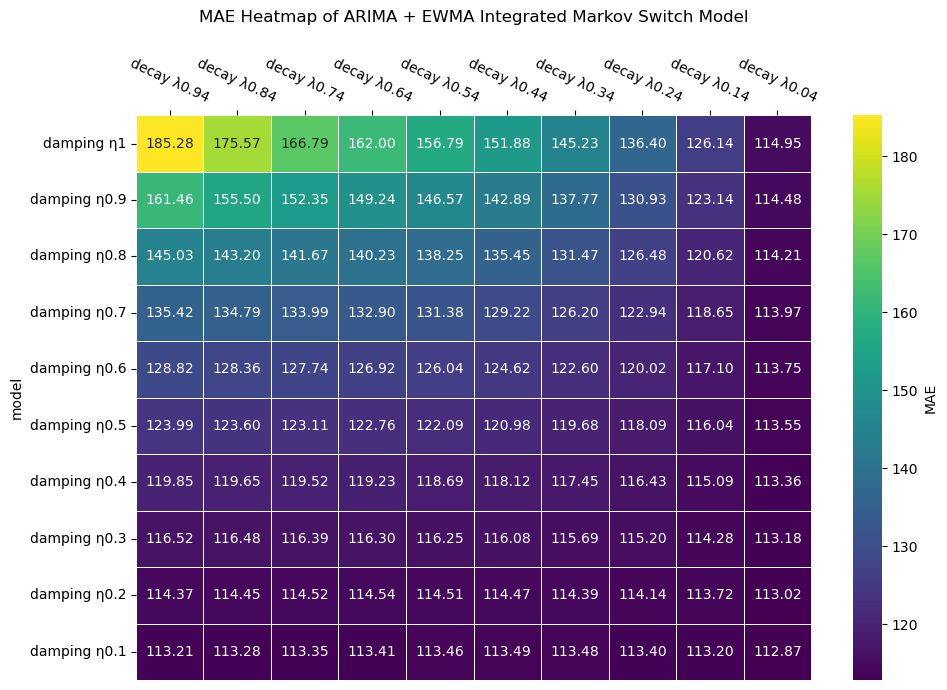

In [89]:
# Heat map to visualize

MAE_matrix.set_index("model", inplace=True)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(MAE_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5, cbar_kws={'label': 'MAE'}) 
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.title('MAE Heatmap of ARIMA + EWMA Integrated Markov Switch Model', pad=25)
ax.tick_params(axis='x', rotation=-25)
plt.tight_layout()
plt.show()


# MAE for ARIMA only

In [15]:
MAE(3,0.94,0.8,2)

110.9176992984423

In [102]:
regime_dfholder = cocoa_price[cocoa_price['DATE'] > '2024-08-19']
regime_dfholder

,DATE,PRICE,abs_perc_change,returns,0,1
7676,2024-08-20,6582.12,0.016109,0.015981,9.690277e-01,0.030972
7677,2024-08-21,6574.60,0.001142,-0.001143,9.917922e-01,0.008208
7678,2024-08-22,6613.72,0.005950,0.005933,9.974532e-01,0.002547
7679,2024-08-23,6657.12,0.006562,0.006541,9.973569e-01,0.002643
7680,2024-08-26,6756.52,0.014931,0.014821,9.909562e-01,0.009044
...,...,...,...,...,...,...
7807,2025-02-21,9106.42,0.085846,-0.089756,1.783226e-26,1.000000
7808,2025-02-24,8408.72,0.076616,-0.079710,2.287613e-23,1.000000
7809,2025-02-25,8668.57,0.030902,0.030435,3.546064e-05,0.999965
7810,2025-02-26,9089.95,0.048610,0.047466,5.231370e-08,1.000000


# 3 Day MSM vs ARIMA Only Price plots

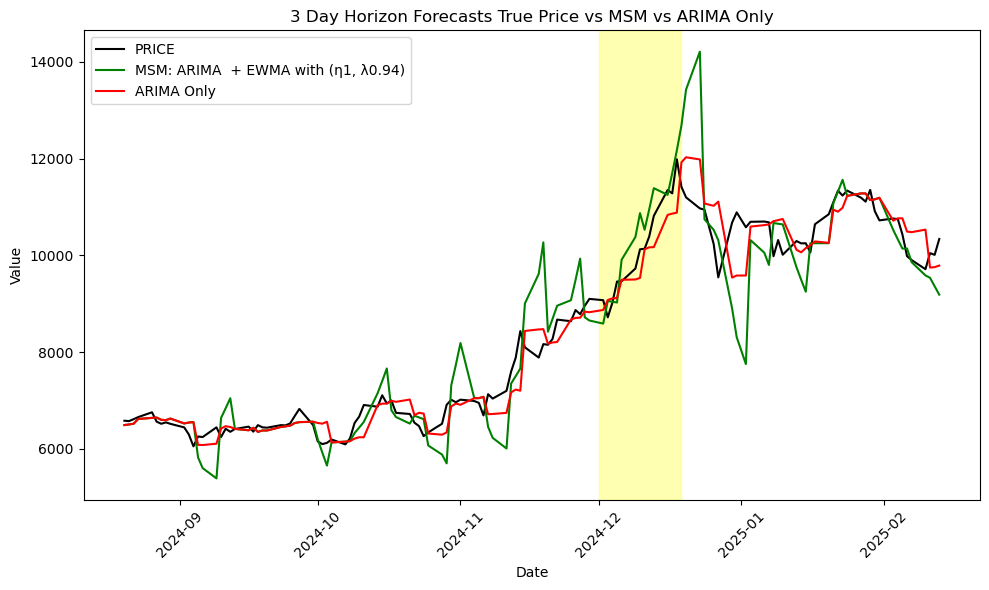

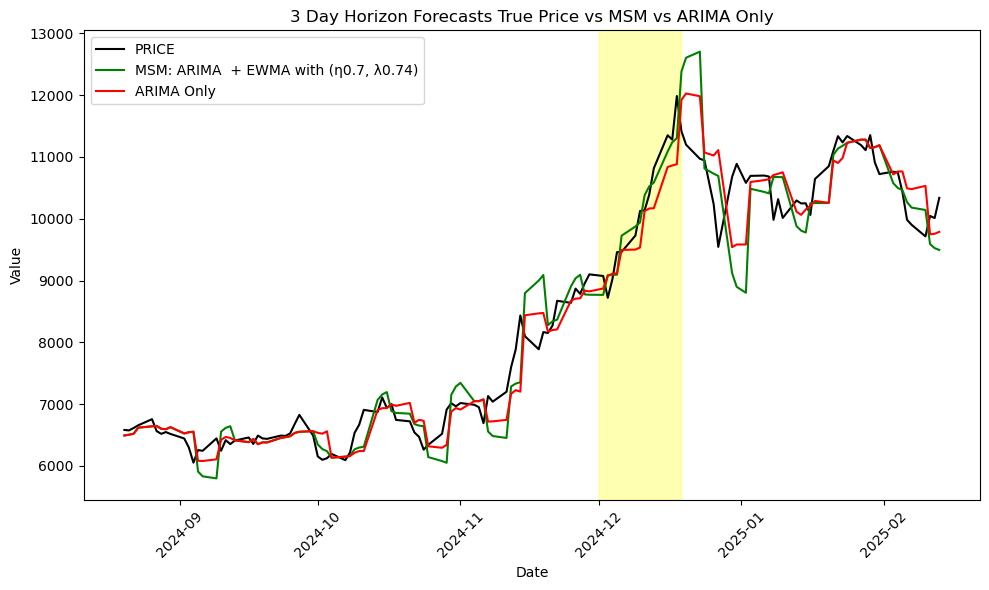

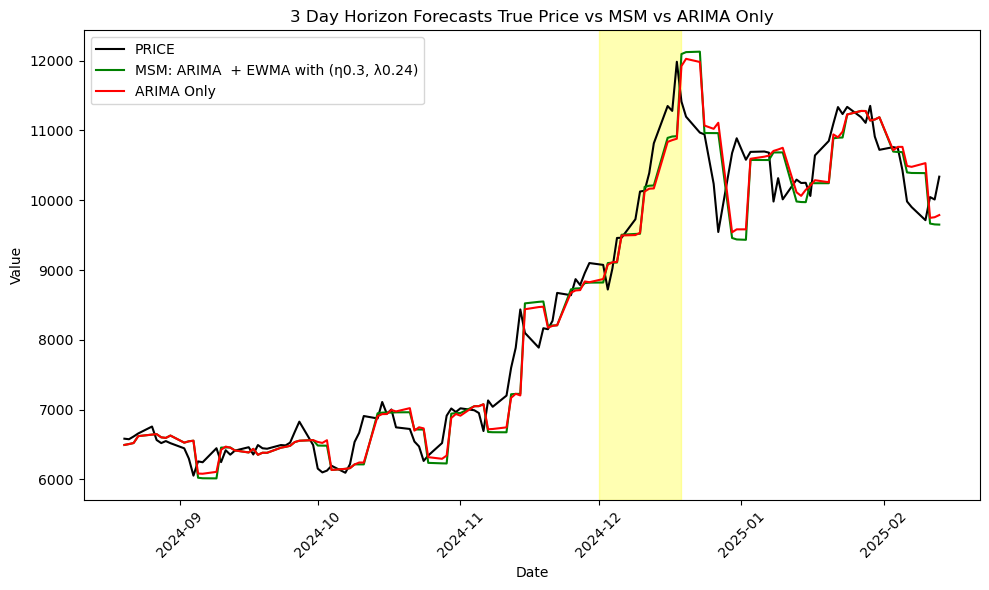

In [112]:
for (damping,decay) in [(1,0.94), (0.7, 0.74), (0.3, 0.24)]:
    df_1day = pd.DataFrame()
    for day in range(42):
        df_1day = pd.concat([df_1day, MSM_forecast(3,day*3,decay,damping, 0)], axis = 0)

    true_price = list(df_1day['PRICE'])

    prediction_m1_1day = list(df_1day['m1_pred_prices'])
    prediction_m2_1day = list(df_1day['m2_pred_prices'])

    model_plot = pd.DataFrame()
    model_plot['DATE'] = df_1day['DATE']
    model_plot['PRICE'] = df_1day['PRICE']
    model_plot[f'm1λ{decay}'] = prediction_m1_1day
    model_plot[f'm2λ{decay}'] = prediction_m2_1day
    
    
    
    
    # Plot
    plt.figure(figsize=(10, 6))

    # Plot each variable with a different color
    plt.plot(model_plot["DATE"], model_plot["PRICE"], label="PRICE", color='black') #price
    plt.plot(model_plot["DATE"], model_plot[f"m1λ{decay}"], label=f"MSM: ARIMA  + EWMA with (η{damping}, λ{decay})", color='green')  # Green line
    plt.plot(model_plot["DATE"], model_plot[f"m2λ{decay}"], label="ARIMA Only", color='red')  # Green line
    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("3 Day Horizon Forecasts True Price vs MSM vs ARIMA Only")
    plt.axvspan(pd.to_datetime('2024-12-01'), pd.to_datetime('2024-12-19'), color='yellow', alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Residual Metrics

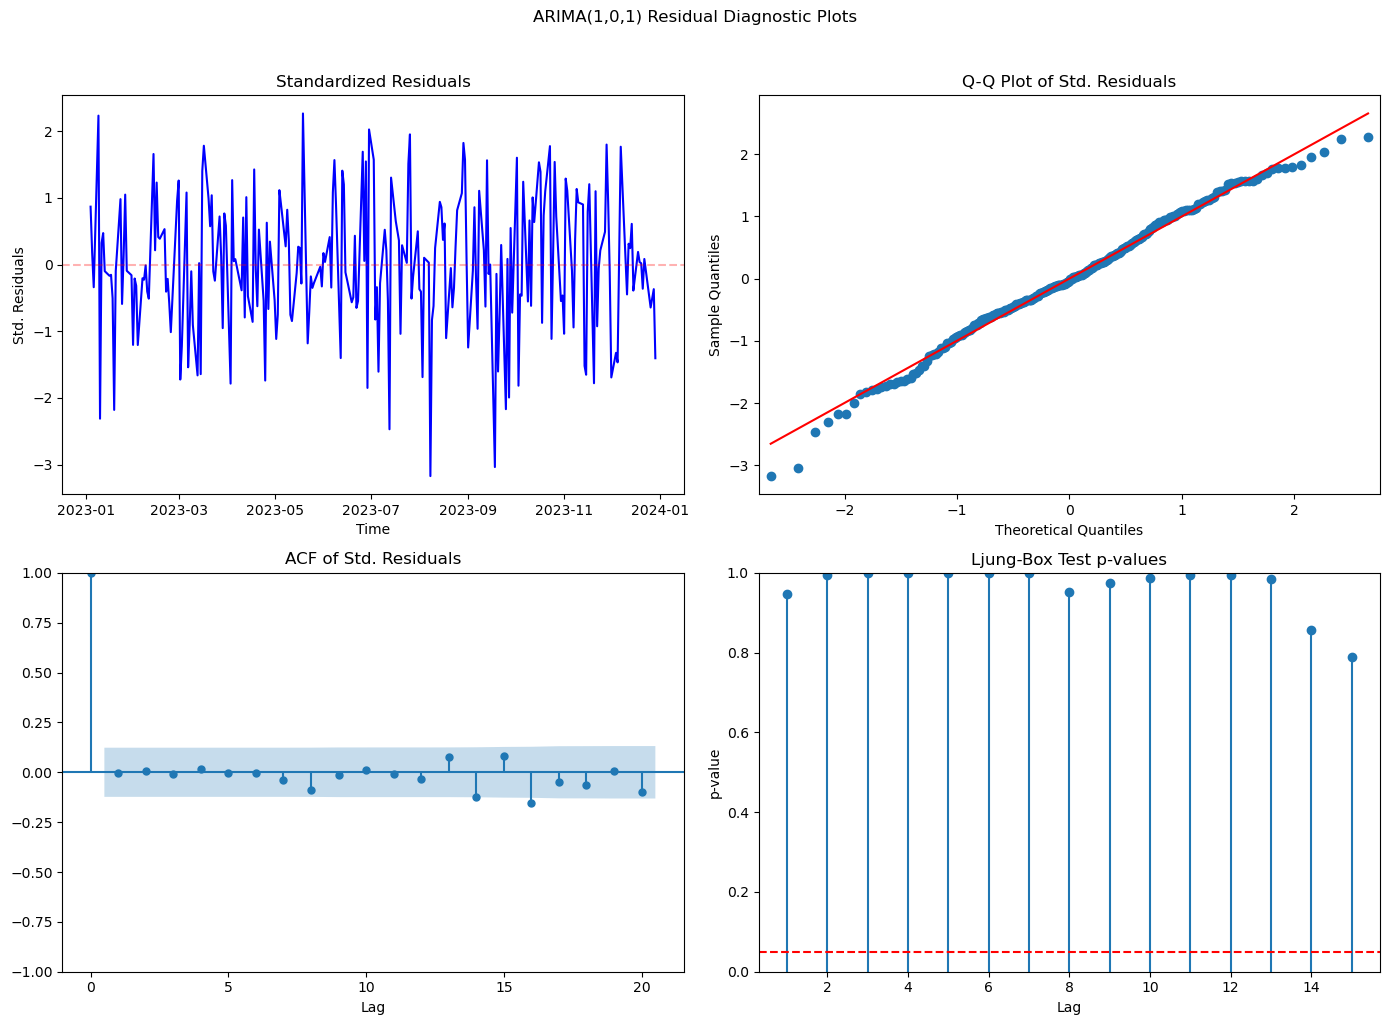

In [39]:
std_residuals = (regime0_model.resid - regime0_model.resid.mean()) / regime0_model.resid.std()

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ARIMA(1,0,1) Residual Diagnostic Plots', y=1.02)

# --- 1. Standardized Residuals Over Time ---
axes[0, 0].plot(cocoa_price_regime0['DATE'], std_residuals, color='blue')
axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.3)
axes[0, 0].set_title('Standardized Residuals')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Std. Residuals')

# --- 2. Q-Q Plot ---
sm.qqplot(std_residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Std. Residuals')

# --- 3. ACF of Residuals ---
plot_acf(std_residuals, lags=20, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF of Std. Residuals')
axes[1, 0].set_xlabel('Lag')

# --- 4. Ljung-Box Test p-values ---
ljung_pvals = acorr_ljungbox(std_residuals, lags=15, return_df=True)['lb_pvalue']
axes[1, 1].stem(range(1, 16), ljung_pvals, basefmt=" ")
axes[1, 1].axhline(0.05, color='red', linestyle='--')
axes[1, 1].set_title('Ljung-Box Test p-values')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('p-value')
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Forecasting ARIMA Only

In [76]:
combined_df = cocoa_price[cocoa_price['DATE']>'2023-01-01']
combined_df = combined_df[['DATE', 'PRICE']]
combined_df['forecast'] = np.nan
combined_df['upper_ci'] = np.nan


arima_forecast_df = pd.DataFrame()
arima_forecast_df['DATE'] = [pd.to_datetime('2025-02-28'), pd.to_datetime('2025-03-03'),pd.to_datetime('2025-03-04')]

# Update the model to most recent price, this does not change the model parameter
updated_model = regime0_model.apply(cocoa_price['returns'], refit=False)

#predict price
predicted_return = list(updated_model.forecast(steps = 3))
last_price = cocoa_price.iloc[-1]['PRICE']
predicted_price = []
for index in range(len(predicted_return)):
    if len(predicted_price) == 0:
        predicted_price.append(last_price * math.exp(predicted_return[index]))
    else:
        predicted_price.append(predicted_price[index - 1] * math.exp(predicted_return[index]))


forecast_result = updated_model.get_forecast(steps=3)

# Extract the confidence intervals (default is 95%)
confidence_intervals = forecast_result.conf_int()
lower_ci = confidence_intervals.iloc[:, 0]
upper_ci = confidence_intervals.iloc[:, 1]

# predict lower
predicted_lower_return = list(lower_ci)
predicted_lower_price = []
for index in range(len(predicted_lower_return)):
    if len(predicted_lower_price) == 0:
        predicted_lower_price.append(last_price * math.exp(predicted_lower_return[index]))
    else:
        predicted_lower_price.append(predicted_lower_price[index - 1] * math.exp(predicted_lower_return[index]))

# predict upper
predicted_upper_return = list(upper_ci)
predicted_upper_price = []
for index in range(len(predicted_upper_return)):
    if len(predicted_upper_price) == 0:
        predicted_upper_price.append(last_price * math.exp(predicted_upper_return[index]))
    else:
        predicted_upper_price.append(predicted_upper_price[index - 1] * math.exp(predicted_upper_return[index]))        
        
arima_forecast_df['PRICE'] = np.nan
arima_forecast_df['forecast'] = predicted_price
arima_forecast_df['lower_ci'] = predicted_lower_price
arima_forecast_df['upper_ci'] = predicted_upper_price

combined_df = pd.concat([combined_df, arima_forecast_df], axis = 0)
print(f'predicted price:{predicted_price}')


predicted price:[9121.240403373602, 9138.291114503594, 9159.504622690902]


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

In [86]:
combined_df

,DATE,PRICE,forecast,upper_ci,lower_ci
7257,2023-01-04,2512.98,NaN,NaN,NaN
7258,2023-01-05,2520.64,NaN,NaN,NaN
7259,2023-01-06,2518.50,NaN,NaN,NaN
7260,2023-01-09,2584.13,NaN,NaN,NaN
7261,2023-01-10,2521.95,NaN,NaN,NaN
...,...,...,...,...,...
7810,2025-02-26,9089.95,NaN,NaN,NaN
7811,2025-02-27,9099.66,NaN,NaN,NaN
0,2025-02-28,NaN,9121.240403,9314.101471,8932.372785
1,2025-03-03,NaN,9138.291115,9529.399041,8763.235135


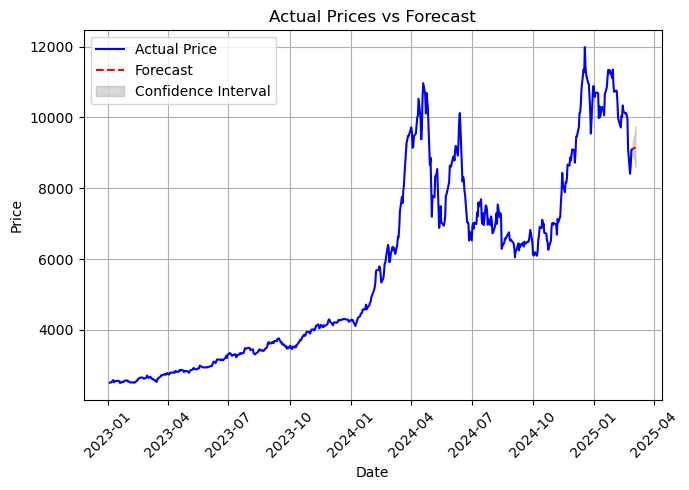

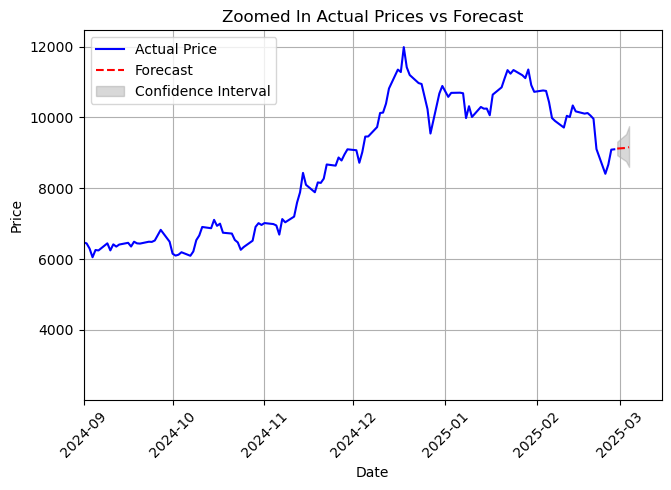

In [85]:
# Plot actual prices
plt.figure(figsize=(7, 5))
plt.plot(combined_df["DATE"], combined_df["PRICE"], linestyle="-", label="Actual Price", color="blue")

# Plot forecasted prices
plt.plot(combined_df["DATE"], combined_df["forecast"], linestyle="--", label="Forecast", color="red")

# Confidence intervals
plt.fill_between(combined_df["DATE"], combined_df["lower_ci"], combined_df["upper_ci"], color="gray", alpha=0.3, label="Confidence Interval")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Actual Prices vs Forecast")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Show the plot
plt.show()


# Plot actual prices
plt.figure(figsize=(7, 5))
plt.plot(combined_df["DATE"], combined_df["PRICE"], linestyle="-", label="Actual Price", color="blue")

# Plot forecasted prices
plt.plot(combined_df["DATE"], combined_df["forecast"], linestyle="--", label="Forecast", color="red")

# Confidence intervals
plt.fill_between(combined_df["DATE"], combined_df["lower_ci"], combined_df["upper_ci"], color="gray", alpha=0.3, label="Confidence Interval")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Price")

plt.title("Zoomed In Actual Prices vs Forecast")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(pd.to_datetime('2024-09-01'), pd.to_datetime('2025-03-15'))
# Show the plot
plt.show()

# LSTM

In [439]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

# Assume cocoa_price is already loaded with columns 'DATE' and 'PRICE'

# 1. Data Preprocessing
def prepare_data(df, look_back=60):
    # Ensure the dataframe is sorted by date
    df = df.sort_values('DATE')
    
    # Extract the price column and convert to numpy array
    prices = df['PRICE'].values.reshape(-1, 1)
    
    # Scale the data to be between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    prices_scaled = scaler.fit_transform(prices)
    
    # Create the dataset with sequences
    X, y = [], []
    for i in range(len(prices_scaled) - look_back):
        X.append(prices_scaled[i:(i + look_back), 0])
        y.append(prices_scaled[i + look_back, 0])
    
    # Convert to numpy arrays and reshape for LSTM [samples, time steps, features]
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Split the data into training and testing sets (80-20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, y_train, X_test, y_test, scaler

# 2. Build LSTM Model
def build_lstm_model(look_back):
    model = Sequential()
    
    # First LSTM layer with dropout
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer with dropout
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# 3. Train, evaluate, and make predictions
def train_and_predict(cocoa_price):
    # Define hyperparameters
    look_back = 60  # Number of previous time steps to use as input features
    
    # Prepare the data
    X_train, y_train, X_test, y_test, scaler = prepare_data(cocoa_price, look_back)
    
    # Build the model
    model = build_lstm_model(look_back)
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Invert predictions back to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate RMSE
    train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))
    print(f'Train RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')
    
    # Plot the results
    plt.figure(figsize=(16, 8))
    
    # Plot training data
    train_dates = cocoa_price['DATE'].values[look_back:look_back+len(train_predict)]
    plt.plot(train_dates, y_train_inv, label='Actual Prices (Training)')
    plt.plot(train_dates, train_predict, label='Predicted Prices (Training)')
    
    # Plot testing data
    test_dates = cocoa_price['DATE'].values[look_back+len(train_predict):look_back+len(train_predict)+len(test_predict)]
    plt.plot(test_dates, y_test_inv, label='Actual Prices (Testing)')
    plt.plot(test_dates, test_predict, label='Predicted Prices (Testing)')
    
    plt.title('Cocoa Price Prediction using LSTM', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return model, history, scaler

# 4. Function to forecast future prices
def forecast_future(model, cocoa_price, scaler, look_back=60, days_to_predict=30):
    # Get the last sequence of known prices
    last_sequence = cocoa_price['PRICE'].values[-look_back:].reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)
    
    # Initialize the list for future predictions
    predictions = []
    current_sequence = last_sequence_scaled.reshape(1, look_back, 1)
    
    # Predict future prices
    for _ in range(days_to_predict):
        # Get the prediction
        next_pred = model.predict(current_sequence)[0]
        predictions.append(next_pred)
        
        # Update the sequence by removing the first element and adding the prediction
        current_sequence = np.append(current_sequence[:, 1:, :], [[next_pred]], axis=1)
    
    # Convert predictions back to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    # Create future dates
    last_date = pd.to_datetime(cocoa_price['DATE'].iloc[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)
    
    # Create a dataframe for the predictions
    future_df = pd.DataFrame({
        'DATE': future_dates,
        'PRICE': predictions.flatten()
    })
    
    # Plot the forecast
    plt.figure(figsize=(16, 8))
    
    # Plot historical data
    plt.plot(cocoa_price['DATE'], cocoa_price['PRICE'], label='Historical Prices')
    
    # Plot forecast
    plt.plot(future_df['DATE'], future_df['PRICE'], label='Forecasted Prices', color='red')
    
    plt.title('Cocoa Price Forecast', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return future_df
    


Epoch 1/100
29/29 [==============================] - 4s 48ms/step - loss: 6.6150e-04 - val_loss: 3.6711e-04
Epoch 2/100
29/29 [==============================] - 1s 26ms/step - loss: 1.0602e-04 - val_loss: 3.5550e-04
Epoch 3/100
29/29 [==============================] - 1s 26ms/step - loss: 8.7213e-05 - val_loss: 0.0012
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 7.7235e-05 - val_loss: 8.3313e-04
Epoch 5/100
29/29 [==============================] - 1s 26ms/step - loss: 7.6905e-05 - val_loss: 6.4217e-04
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 7.3302e-05 - val_loss: 3.4759e-04
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 7.2709e-05 - val_loss: 5.3393e-04
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 6.5324e-05 - val_loss: 4.7391e-04
Epoch 9/100
29/29 [==============================] - 1s 26ms/step - loss: 6.4207e-05 - val_loss: 3.9018e-04
Epoch 10/100
29/29 [============

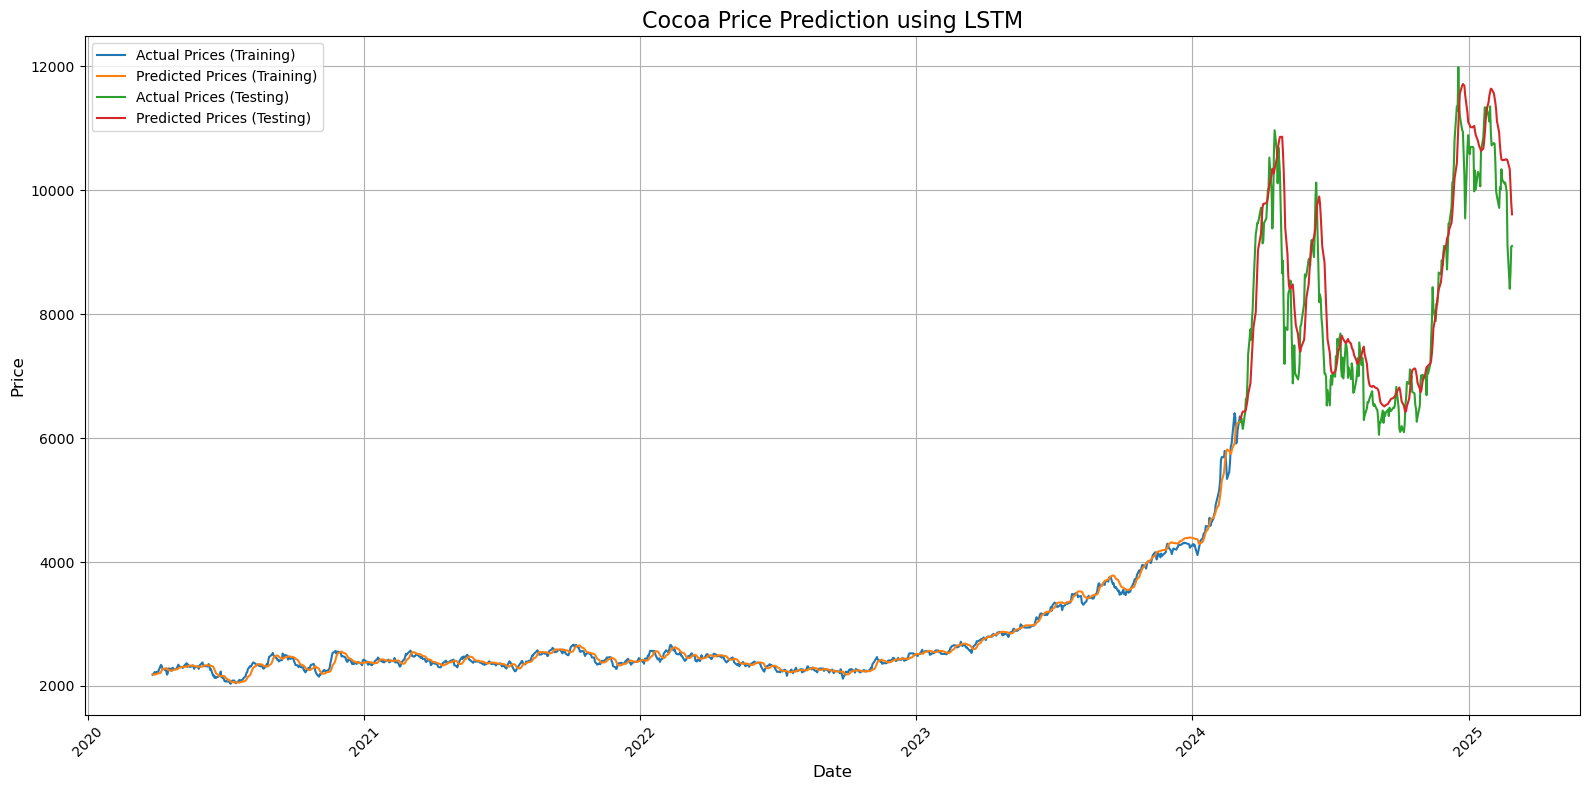

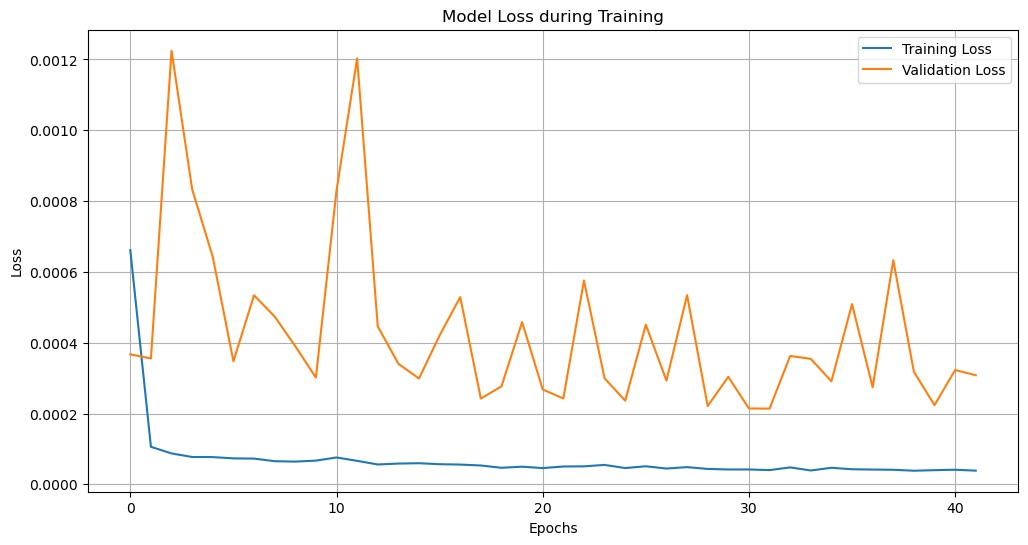

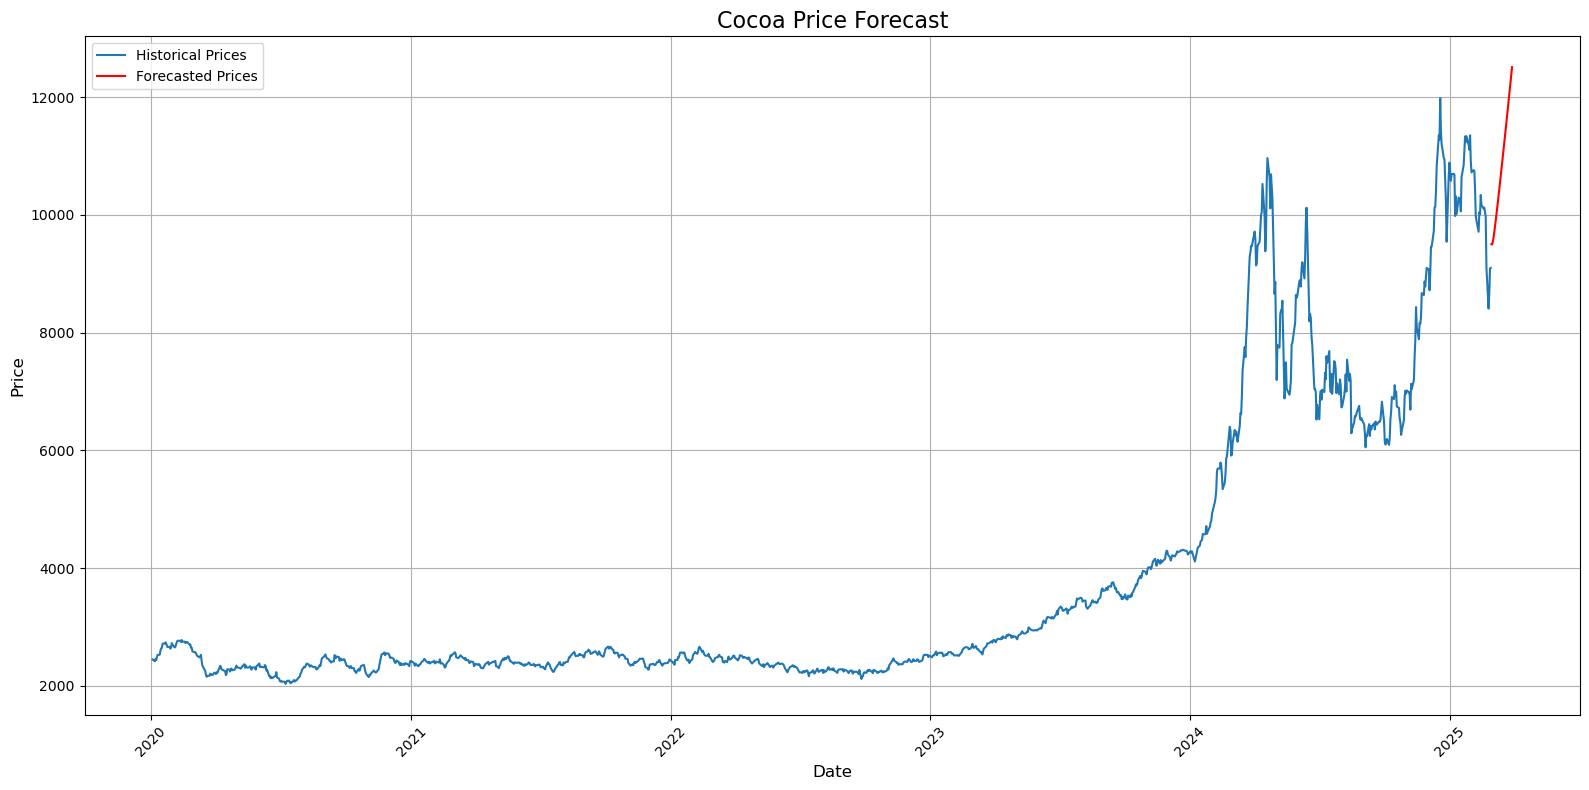

In [440]:
    # Main workflow
model, history, scaler = train_and_predict(cocoa_price)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Generate future predictions
future_prices = forecast_future(model, cocoa_price, scaler, days_to_predict=30)
print("Future price predictions:")
print(future_prices.head())

In [481]:
# LSTM Model for Regime 1 (High Volatility)
def create_lstm_model(cocoa_price, look_back=30):
    """
    Create and train LSTM model on historical cocoa price returns
    """
    # Preprocessing: Use returns instead of raw prices for LSTM
    data = cocoa_price[['DATE', 'PRICE', 'returns']].copy()
    data = data.dropna()
    
    # Scale the returns data
    scaler = MinMaxScaler(feature_range=(0, 1))
    returns_scaled = scaler.fit_transform(data['PRICE'].values.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(returns_scaled) - look_back):
        X.append(returns_scaled[i:(i + look_back), 0])
        y.append(returns_scaled[i + look_back, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        epochs=100, 
        batch_size=32, 
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )
    
    return model, scaler, look_back

# Function to forecast using LSTM
def lstm_forecast(model, scaler, last_returns, look_back, steps):
    """
    Forecast returns using LSTM model
    """
    # Filter out NaN values and get the last sequence of returns
    filtered_returns = [x for x in last_returns if not np.isnan(x)][-look_back:]
    last_sequence = np.array(filtered_returns).reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)
    
    # Initialize sequence for prediction
    current_batch = last_sequence_scaled.reshape(1, look_back, 1)
    
    # Make predictions
    predicted_returns = []
    for _ in range(steps):
        # Predict next return
        next_return = model.predict(current_batch, verbose=0)[0][0]
        predicted_returns.append(next_return)
        
        # Update sequence for next prediction - FIX: Reshape next_return to maintain dimensions
        next_return_reshaped = np.array([[[next_return]]])  # Shape: (1, 1, 1)
        current_batch = np.concatenate((current_batch[:, 1:, :], next_return_reshaped), axis=1)
    
    # Inverse transform to get actual returns
    predicted_returns = np.array(predicted_returns).reshape(-1, 1)
    return scaler.inverse_transform(predicted_returns).flatten().tolist()

def MSM_forecast(n: int, lamda: int, update: int = 0) -> pd.DataFrame:
    """ 
    Forecasts n days from 2024-08-20
    Optionally forecasts beginning from update
    Returns a dataframe of FIVE columns: [DATE, PRICE, m1_pred_prices, m2_pred_prices, m3_pred_prices, m4_pred_prices]
    (PRICE is true price)
    """
    cocoa_forecast = cocoa_price.loc[:7675 + update]
    
    # last_row.get(): DATE,PRICE,returns,0,1
    last_row = cocoa_forecast.iloc[-1]
    
    # Generate forecasting Dates
    return_df = cocoa_price.loc[7675 + update + 1: 7675 + n + update]
    return_df = return_df[['DATE', 'PRICE']]
    
    # temporary returns_lst
    returns_lst = list(cocoa_forecast['returns'])
    lstm_price_list = list(cocoa_forecast['PRICE'])
    
    # Model 1 - ARIMA or LSTM based on regime
    m1_pred_prices = []
    if last_row.get(0) > 0.5:  # Regime 0 (Low volatility)
        # Apply model to updated data (retain the same coefficients, models is not retrained, just applied.)
        updated_m1 = regime0_model.apply(returns_lst, refit=False)
        # Obtain forecasted returns
        m1_pred_returns = list(updated_m1.forecast(steps=n))
        lstm = False
        
    else:  # Regime 1 (High volatility) - Use LSTM
        # Use the pre-trained LSTM model to forecast returns
        lstm = True
        m1_pred_prices = lstm_forecast(
            model=lstm_model,
            scaler=lstm_scaler,
            last_returns=[x for x in lstm_price_list if not np.isnan(x)][-lstm_look_back:],
            look_back=lstm_look_back,
            steps=n
        )
    
    # Convert returns to prices
    if lstm == False:
        for index in range(len(m1_pred_returns)):
            if m1_pred_prices == []:
                m1_pred_prices.append(math.exp(m1_pred_returns[index]) * last_row.get("PRICE"))
            else:
                m1_pred_prices.append(math.exp(m1_pred_returns[index]) * m1_pred_prices[index - 1])

    
    # Reset
    returns_lst = list(cocoa_forecast['returns'])
    
    # Model 2 - ARIMA ONLY (unchanged)
    m2_pred_prices = []
    # Apply model to updated data (retain the same coefficients, models is not retrained, just applied.)
    updated_m2 = regime0_model101.apply(returns_lst, refit=False)
    # Obtain forecasted returns
    m2_pred_returns = list(updated_m2.forecast(steps=n))
    
    # Convert returns to prices
    for index in range(len(m2_pred_returns)):
        if m2_pred_prices == []:
            m2_pred_prices.append(math.exp(m2_pred_returns[index]) * last_row.get("PRICE"))
        else:
            m2_pred_prices.append(math.exp(m2_pred_returns[index]) * m2_pred_prices[index - 1])
    
    # Assign predictions to dataframe
    return_df['m1_pred_prices'] = m1_pred_prices
    return_df['m2_pred_prices'] = m2_pred_prices
    
    return return_df


In [463]:
lstm_model, lstm_scaler, lstm_look_back = create_lstm_model(cocoa_price)

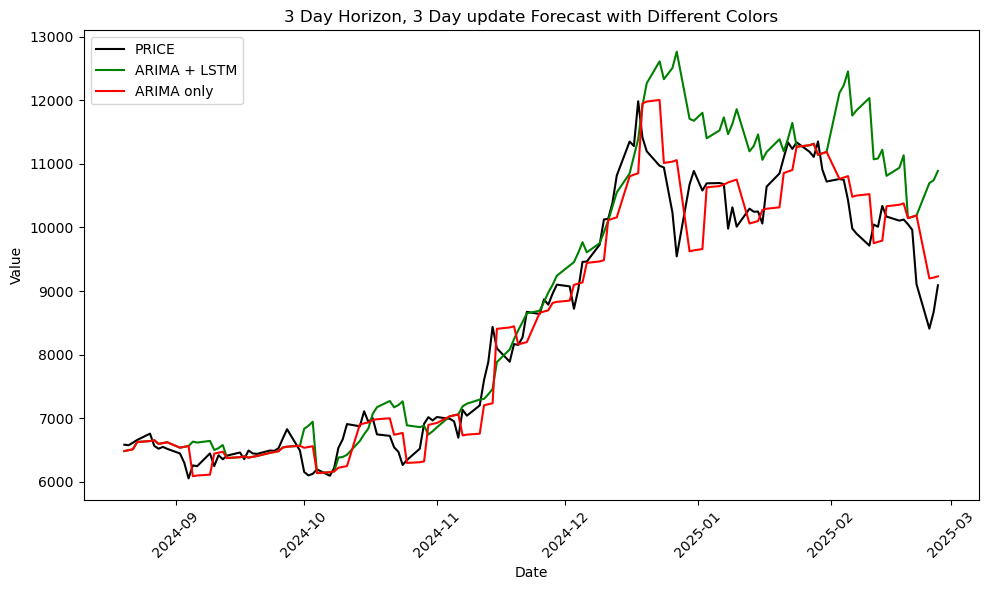

In [498]:
for lamda in [0.94]:
    df_1day = pd.DataFrame()
    for day in range(int(135/3)):
        df_1day = pd.concat([df_1day, MSM_forecast(3,lamda, day*3)], axis = 0)

    true_price = list(df_1day['PRICE'])

    prediction_m1_1day = list(df_1day['m1_pred_prices'])
    prediction_m2_1day = list(df_1day['m2_pred_prices'])
    
    model_plot = pd.DataFrame()
    model_plot['DATE'] = df_1day['DATE']
    model_plot['PRICE'] = df_1day['PRICE']
    model_plot[f'm1λ{lamda}'] = prediction_m1_1day
    model_plot[f'm2λ{lamda}'] = prediction_m2_1day

# Plot
plt.figure(figsize=(10, 6))

# Plot each variable with a different color
plt.plot(model_plot["DATE"], model_plot["PRICE"], label="PRICE", color='black') #price
plt.plot(model_plot["DATE"], model_plot["m1λ0.94"], label="ARIMA + LSTM", color='green')  # Green line
plt.plot(model_plot["DATE"], model_plot["m2λ0.94"], label="ARIMA only", color='red')  # Green line
# Add labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("3 Day Horizon, 3 Day update Forecast with Different Colors")
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Coding Appendix

#### CA - 1: MSM Prediction
One can see that we 

In [1]:
m_df = cocoa_price[cocoa_price['DATE'] < '2024-08-19']
m = MarkovRegression(m_df['abs_perc_change'], k_regimes=2, switching_variance=True)
r = m.fit()

NameError: name 'cocoa_price' is not defined

In [ ]:
# Plot the smoothed probabilities of being in each regime
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(m_df['DATE'], m_df['abs_perc_change'], label='Log Returns', color='black')
ax.fill_between(m_df['DATE'], 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='1 Volatility Regime')
ax.fill_between(m_df['DATE'], 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='2 Volatility Regime')

ax.set_title('Cocoa Returns with Regime Probabilities')
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
ax.legend()
plt.show()


# Cocoa Prices with regime
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot price data on the primary axis
ax1.plot(m_df['DATE'], m_df['PRICE'], label='Price', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot regime probabilities on the secondary axis
ax2.fill_between(m_df['DATE'], 0, results.smoothed_marginal_probabilities[0], 
                color='blue', alpha=0.3, label='1 Volatility Regime')
ax2.fill_between(m_df['DATE'], 0, results.smoothed_marginal_probabilities[1], 
                color='red', alpha=0.3, label='2 Volatility Regime')
ax2.set_ylabel('Regime Probability', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Add a title
fig.suptitle('Cocoa Price with Volatility Regime Probabilities', fontsize=14)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()


#Cocoa Prices with Regime, Zoomed in
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot price data on the primary axis
ax1.plot(m_df['DATE'], m_df['PRICE'], label='Price', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot regime probabilities on the secondary axis
ax2.fill_between(m_df['DATE'], 0, results.smoothed_marginal_probabilities[0], 
                color='blue', alpha=0.3, label='Low Volatility Regime')
ax2.fill_between(m_df['DATE'], 0, results.smoothed_marginal_probabilities[1], 
                color='red', alpha=0.3, label='High Volatility Regime')
ax2.set_ylabel('Regime Probability', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

start_date = "2024-01-01"  # Replace with the desired start date
end_date = "2025-02-27"    # Replace with the desired end date
ax1.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Add a title
fig.suptitle('Cocoa Price with Volatility Regime Probabilities', fontsize=14)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

#### CA - AUTO ARIMA vs ARIMA

In [ ]:
regime0_model